##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Feature Inversion Caricatures

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce feature inversion caricatures that are similar in spirit to the activation grids in [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/). 

This is slightly similar to the technique described by [Mahendran and Vedaldi](https://arxiv.org/pdf/1412.0035.pdf). However, we use a dot product objective, instead of L2 difference, and use transformation robustness to reduce artifacts. 

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [2]:
# Install Lucid
!pip install --quiet lucid==0.0.5

# Import libraries
import numpy as np
import tensorflow as tf
import scipy.ndimage as nd

from google.colab import files

import lucid.modelzoo.vision_models as models
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform
from lucid.misc.io import show, load
from lucid.misc.io.reading import read

In [0]:
# Import the InceptionV1 (GoogLeNet) model from the Lucid modelzoo

model = models.InceptionV1()
model.load_graphdef()

## Setup

In [0]:
def imgToModelSize(arr):
  W = model.image_shape[0]
  w, h, _ = arr.shape
  s = float(W) / min(w,h)
  arr = nd.zoom(arr, [s, s, 1], mode="nearest")
  w, h, _ = arr.shape
  dw, dh = (w-W)//2, (h-W)//3
  return arr[dw:dw+W, dh:dh+W]

In [0]:
@objectives.wrap_objective
def dot_compare(layer, batch=1, cossim_pow=0):
  def inner(T):
    dot = tf.reduce_sum(T(layer)[batch] * T(layer)[0])
    mag = tf.sqrt(tf.reduce_sum(T(layer)[0]**2))
    cossim = dot/(1e-6 + mag)
    return dot * cossim ** cossim_pow
  return inner

In [0]:
def feature_inversion(img=None, layer=None, n_steps=512, cossim_pow=0.0):
  with tf.Graph().as_default(), tf.Session() as sess:
    img = imgToModelSize(img)
    
    objective = objectives.Objective.sum([
        1.0 * dot_compare(layer, cossim_pow=cossim_pow),
        objectives.blur_input_each_step(),
    ])

    t_input = tf.placeholder(tf.float32, img.shape)
    param_f = param.image(img.shape[0], decorrelate=True, fft=True, alpha=False)
    param_f = tf.stack([param_f[0], t_input])

    transforms = [
      transform.pad(8, mode='constant', constant_value=.5),
      transform.jitter(8),
      transform.random_scale([0.9, 0.95, 1.05, 1.1] + [1]*4),
      transform.random_rotate(range(-5, 5) + [0]*5),
      transform.jitter(2),
    ]

    T = render.make_vis_T(model, objective, param_f, transforms=transforms)
    loss, vis_op, t_image = T("loss"), T("vis_op"), T("input")

    tf.global_variables_initializer().run()
    for i in range(n_steps): _ = sess.run([vis_op], {t_input: img})

    result = t_image.eval(feed_dict={t_input: img})
    show(result[0])

# Caricatures for All Layeres

In [0]:
img = load("https://storage.googleapis.com/lucid-static/building-blocks/examples/dog_cat.png")

layers = ['conv2d%d' % i for i in range(0, 3)] + ['mixed3a', 'mixed3b', 
                                                  'mixed4a', 'mixed4b', 'mixed4c', 'mixed4d', 'mixed4e',
                                                  'mixed5a', 'mixed5b']

conv2d0



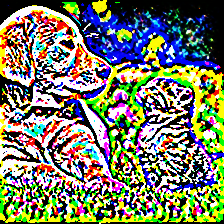


conv2d1



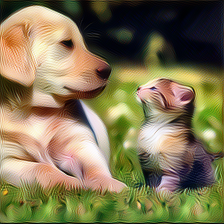


conv2d2



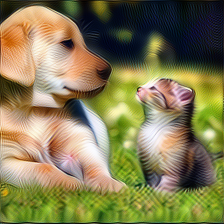


mixed3a



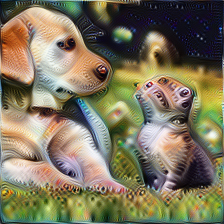


mixed3b



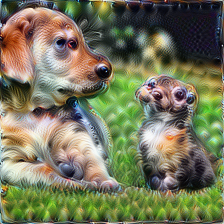


mixed4a



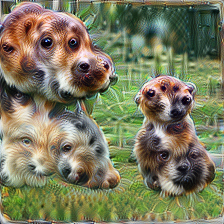


mixed4b



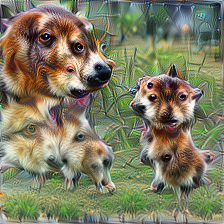


mixed4c



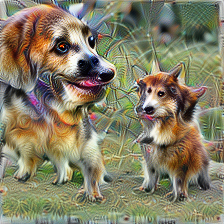


mixed4d



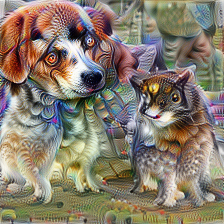


mixed4e



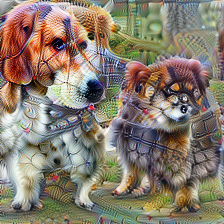


mixed5a



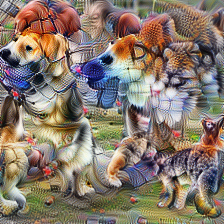


mixed5b



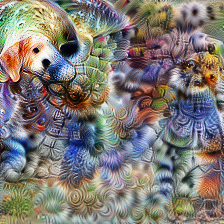

In [37]:
for layer in layers:
  print layer
  feature_inversion(img, layer=layer)
  print ""

## Varying Cossine Similarity

The naive objective is to just maximize the dot product. But, if we want to encourage the objective to care more about the angle of the activations, we can increase the cossine similarity. This forces the caricature to be closer to the original activations.

0.0



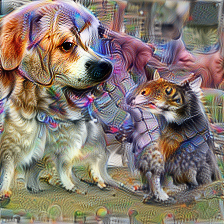


0.5



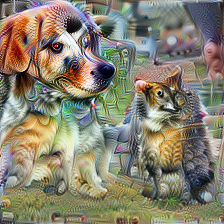


1.0



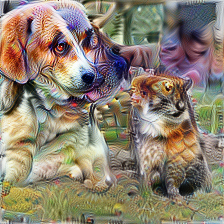


2.0



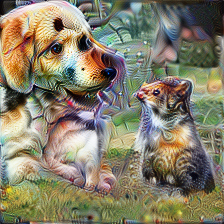

In [44]:
for cossim in [0.0, 0.5, 1.0, 2.0]:
  print cossim
  feature_inversion(img, layer='mixed4d', cossim_pow=cossim)
  print ""

# Upload Your Own Image

Saving flowers.jpeg to flowers.jpeg



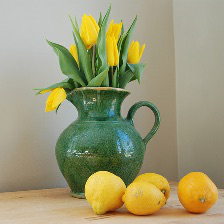


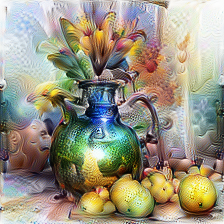

In [33]:
uploaded = files.upload()
for fn in uploaded.keys():
  img = load(fn)
  show(imgToModelSize(img))
  feature_inversion(img, layer='mixed4d')